<a href="https://colab.research.google.com/github/bluesparrow09/ESP32-Power-Saving-Lab/blob/main/final_project_data%26feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install librosa numpy matplotlib

In [ ]:
# gdown
!pip install gdown

# download file
FILE_ID = "1RG4kRSK3kEYjks9SsAvUibjjZ2KLVWLG"
!gdown --id $FILE_ID

# zip
!unzip -q RAVDESS_Speech.zip -d /content/data

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1RG4kRSK3kEYjks9SsAvUibjjZ2KLVWLG
From (redirected): https://drive.google.com/uc?id=1RG4kRSK3kEYjks9SsAvUibjjZ2KLVWLG&confirm=t&uuid=e9a98449-0b02-4be8-85c8-f1146b6bcc47
To: /content/RAVDESS_Speech.zip
100% 208M/208M [00:03<00:00, 66.7MB/s]


In [ ]:
# 3. Feature extraction
# ----------------------------
import librosa
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import librosa.display

def extract_features(file_path, n_fft=2048, hop_length=512, n_mfcc=40):
    """Extract raw time-frequency features"""
    y, sr = librosa.load(file_path, sr=16000)
    y = librosa.effects.preemphasis(y)

    # Calculate MFCCs (keep time dimension)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                               n_fft=n_fft, hop_length=hop_length)

    # Calculate STFT magnitude spectrum (log scale)
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    stft_mag = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    return mfcc.T, stft_mag.T  # Transpose to (time_frames, features)

# Initialize feature containers
mfcc_features = []
stft_features = []
labels = []

# Process all audio files
for root, _, files in os.walk("/content/data"):
    for file in files:
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            labels.append(emotion_code)

            mfcc, stft = extract_features(os.path.join(root, file))
            mfcc_features.append(mfcc)
            stft_features.append(stft)

In [ ]:
# 4. Feature Normalization with Padding
# --------------------------------------------------

import numpy as np
from sklearn.preprocessing import StandardScaler

def normalize_features(feature_list, feature_type='mfcc'):
    """
    Normalize features with dynamic padding and channel-wise standardization
    Args:
        feature_list: List of 2D features (time × features)
        feature_type: 'mfcc' or 'stft' (for dimension handling)
    Returns:
        Normalized and padded 3D array (samples × max_time × features)
    """
    # 1. Find maximum time dimension
    max_time = max([s.shape[0] for s in feature_list])

    # 2. Zero-pad sequences to match max_time
    if feature_type == 'mfcc':
        # MFCC shape: (time, n_mfcc)
        padded = [np.pad(s, ((0, max_time-s.shape[0]), (0,0)), mode='constant')
                 for s in feature_list]
    elif feature_type == 'stft':
        # STFT shape: (time, n_freq)
        padded = [np.pad(s, ((0, max_time-s.shape[0]), (0,0)), mode='constant')
                 for s in feature_list]

    # 3. Convert to 3D numpy array
    padded_array = np.array(padded)

    # 4. Channel-wise standardization (per frequency band/MFCC coefficient)
    scaler = StandardScaler()
    n_samples, n_time, n_features = padded_array.shape

    # Reshape to 2D (samples*time, features) for scaling
    reshaped = padded_array.reshape(-1, n_features)
    normalized = scaler.fit_transform(reshaped)

    # Reshape back to 3D
    return normalized.reshape(n_samples, n_time, n_features)

# Normalize MFCC features
mfcc_normalized = normalize_features(mfcc_features, 'mfcc')

# Normalize STFT features
stft_normalized = normalize_features(stft_features, 'stft')

# 5. Verification
print("Normalized feature shapes:")
print(f"MFCC: {mfcc_normalized.shape} (samples × time × features)")
print(f"STFT: {stft_normalized.shape} (samples × time × freq_bins)")
print(f"Sample MFCC range: {np.min(mfcc_normalized):.2f} to {np.max(mfcc_normalized):.2f}")
print(f"Sample STFT range: {np.min(stft_normalized):.2f} to {np.max(stft_normalized):.2f}")

Normalized feature shapes:
MFCC: (1440, 165, 40) (samples × time × features)
STFT: (1440, 165, 1025) (samples × time × freq_bins)
Sample MFCC range: -8.49 to 12.09
Sample STFT range: -1.24 to 1.54


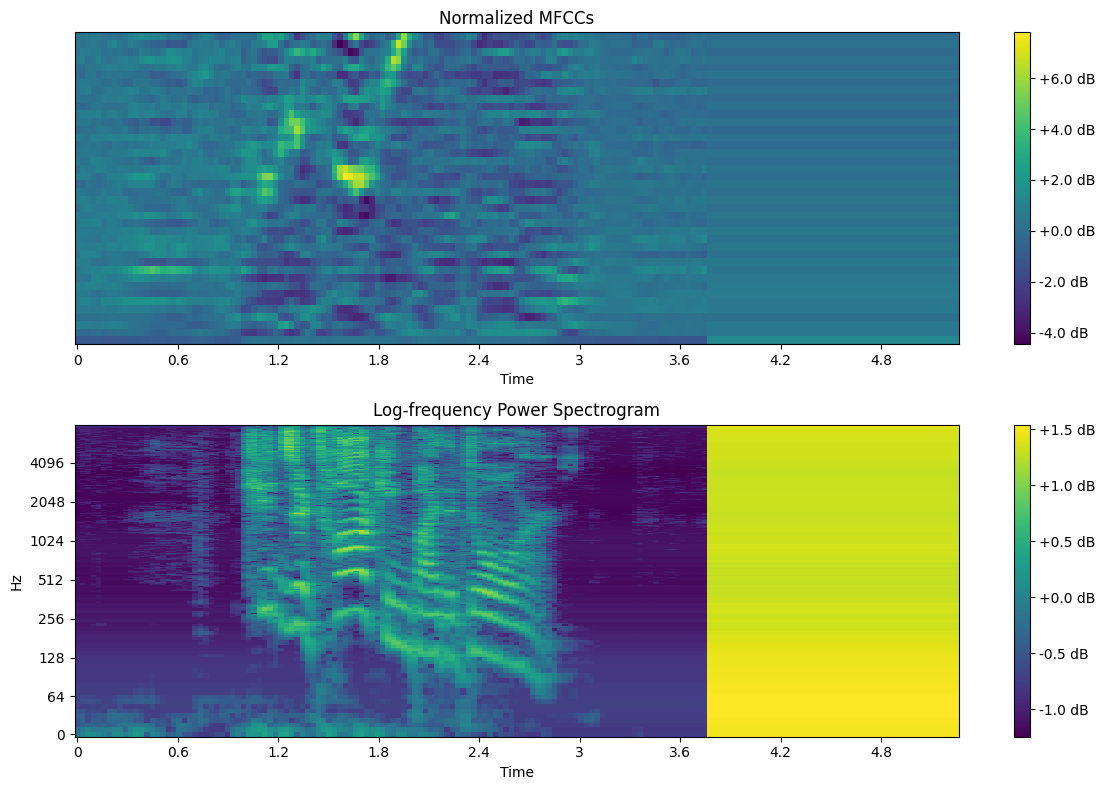

Feature shapes:
MFCC: (1440, 165, 40) (samples × time × features)
STFT: (1440, 165, 1025) (samples × time × freq_bins)
Labels: (1440,)


<Figure size 640x480 with 0 Axes>

In [ ]:
# 6. Visualization
# ----------------------------
def plot_spectral_features(sample_idx=0):
    """Visualize MFCC and STFT features"""
    # Get sample features
    mfcc_sample = mfcc_normalized[sample_idx].T  # (features, time)
    stft_sample = stft_normalized[sample_idx].T  # (freq, time)

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot MFCCs
    plt.subplot(2, 1, 1)
    librosa.display.specshow(
        mfcc_sample,
        x_axis="time",
        sr=16000,
        hop_length=512,
        cmap="viridis"
    )
    plt.colorbar(format="%+2.1f dB")
    plt.title("Normalized MFCCs")

    # Plot STFT
    plt.subplot(2, 1, 2)
    librosa.display.specshow(
        stft_sample,
        x_axis="time",
        y_axis="log",
        sr=16000,
        hop_length=512,
        cmap="viridis"
    )
    plt.colorbar(format="%+2.1f dB")
    plt.title("Log-frequency Power Spectrogram")

    plt.tight_layout()
    plt.show()

# Generate visualization
plot_spectral_features(sample_idx=0)

# 7. Verification
# ----------------------------
print("Feature shapes:")
print(f"MFCC: {mfcc_normalized.shape} (samples × time × features)")
print(f"STFT: {stft_normalized.shape} (samples × time × freq_bins)")
print(f"Labels: {np.array(labels).shape}")

# 8. Save visualization
# ----------------------------
plt.savefig(os.path.join(output_dir, "spectral_features.png"), dpi=300)

In [ ]:
!rm /content/features/X_mfcc.npy /content/features/X_stft.npy

!ls /content/features

rm: cannot remove '/content/features/X_mfcc.npy': No such file or directory
rm: cannot remove '/content/features/X_stft.npy': No such file or directory
combined_spectral_features_normalized_corrected.png  mfcc_static.png	    X_stft_normalized.npy
combined_spectral_features_normalized.png	     spectral_features.png  y_labels.npy
combined_spectral_features.png			     stft_plot.png
mfcc_plot.png					     X_mfcc_normalized.npy


In [ ]:
!zip -r /content/features_to_share.zip \
  /content/features/X_mfcc_normalized.npy \
  /content/features/X_stft_normalized.npy \
  /content/features/y_labels.npy

updating: content/features/X_mfcc_normalized.npy (deflated 7%)
updating: content/features/X_stft_normalized.npy (deflated 9%)
updating: content/features/y_labels.npy (deflated 90%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/features.zip" "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


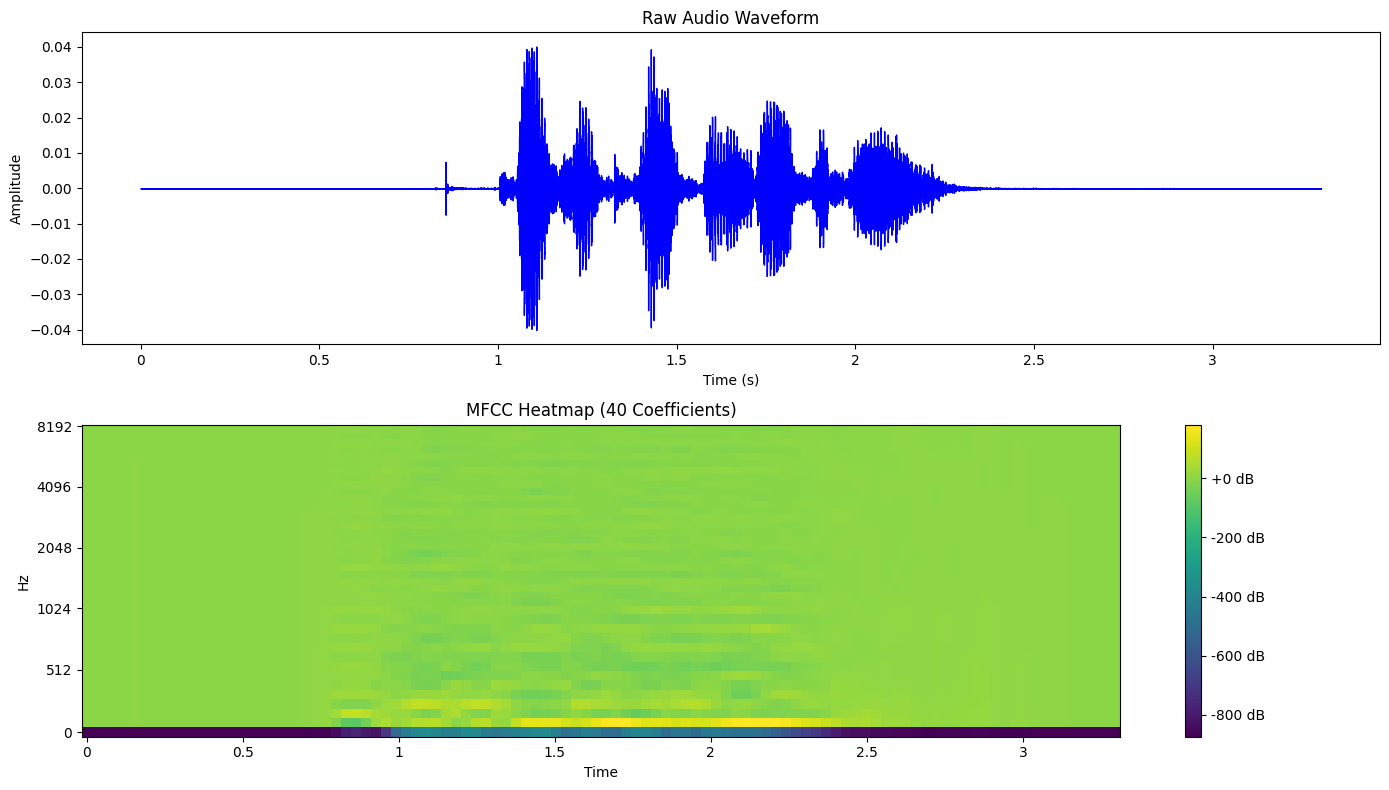

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 加载一个音频文件（替换为你的实际路径）
audio_path = "/content/data/Actor_01/03-01-01-01-01-01-01.wav"  # 示例：中性情绪
y, sr = librosa.load(audio_path, sr=16000)

# 创建画布
plt.figure(figsize=(14, 8))

# --- 子图1：原始波形 ---
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, color="blue")
plt.title("Raw Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# --- 子图2：MFCC热力图 ---
plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfcc, x_axis="time", y_axis="mel",
                        sr=sr, hop_length=512, cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title("MFCC Heatmap (40 Coefficients)")

# 调整布局并保存
plt.tight_layout()
plt.savefig("/content/features/waveform_vs_mfcc.png", dpi=300)
plt.show()

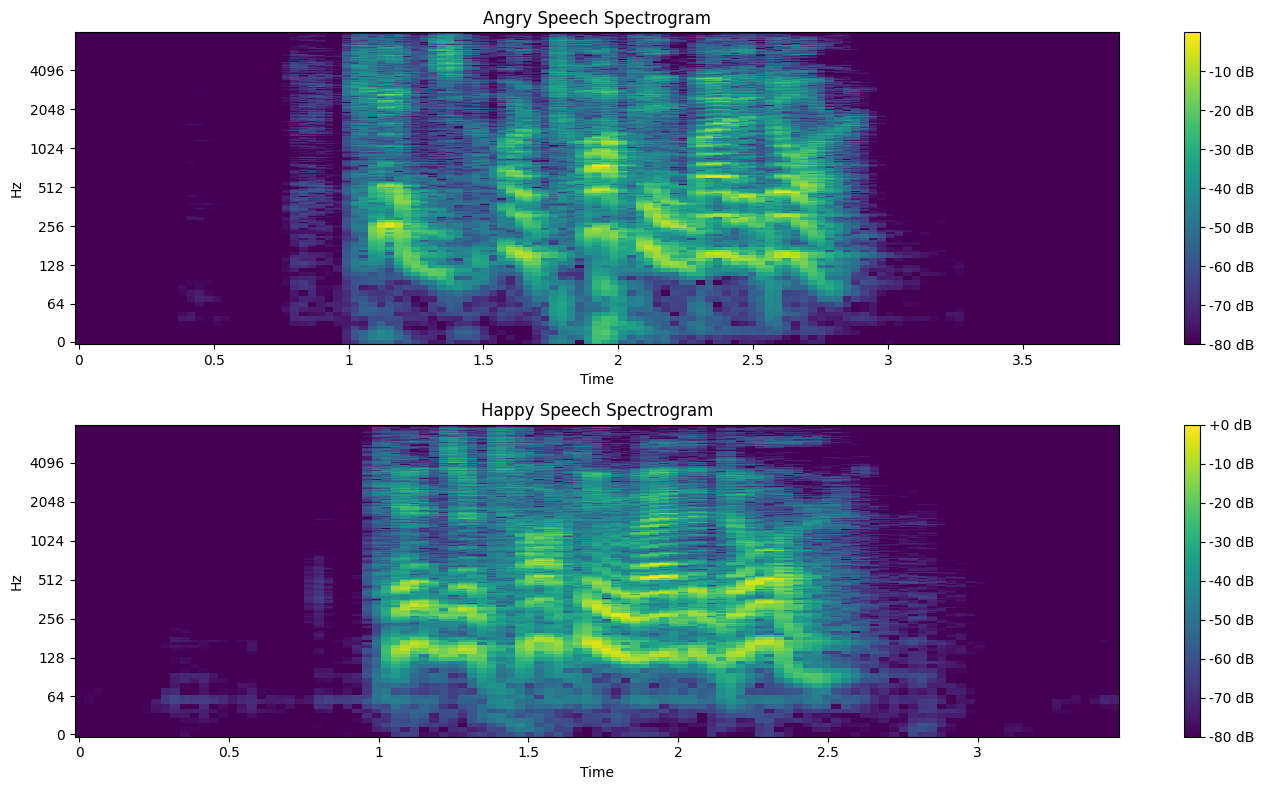

In [ ]:
# 加载生气和开心的音频样本（替换为你的实际路径）
angry_path = "/content/data/Actor_01/03-01-05-01-01-01-01.wav"  # RAVDESS中"05"=生气
happy_path = "/content/data/Actor_01/03-01-03-01-01-01-01.wav"  # RAVDESS中"03"=开心

y_angry, sr = librosa.load(angry_path, sr=16000)
y_happy, sr = librosa.load(happy_path, sr=16000)

# 计算STFT频谱
stft_angry = np.abs(librosa.stft(y_angry))
stft_happy = np.abs(librosa.stft(y_happy))

# 创建画布
plt.figure(figsize=(14, 8))

# --- 子图1：生气频谱 ---
plt.subplot(2, 1, 1)
stft_db_angry = librosa.amplitude_to_db(stft_angry, ref=np.max)
librosa.display.specshow(stft_db_angry, x_axis="time", y_axis="log",
                        sr=sr, hop_length=512, cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title("Angry Speech Spectrogram")

# --- 子图2：开心频谱 ---
plt.subplot(2, 1, 2)
stft_db_happy = librosa.amplitude_to_db(stft_happy, ref=np.max)
librosa.display.specshow(stft_db_happy, x_axis="time", y_axis="log",
                        sr=sr, hop_length=512, cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title("Happy Speech Spectrogram")

# 调整布局并保存
plt.tight_layout()
plt.savefig("/content/features/angry_vs_happy_spectrogram.png", dpi=300)
plt.show()